# Donor Segmentation & Growth Analysis

**Strategic Analysis for Development Leadership**

This analysis focuses on donor segmentation strategies and growth opportunities to maximize fundraising effectiveness and identify high-value donor prospects.

## Analysis Objectives
- Segment donors by giving capacity and behavior patterns
- Identify growth opportunities within existing donor base
- Analyze donor upgrade patterns and potential
- Provide data-driven recommendations for cultivation strategies

⚠️ **SAFETY NOTE**: This notebook contains only read-only operations for safety.
Database-modifying operations are commented out to prevent accidental changes.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from neon_crm import NeonClient

# Configure visualization style
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Initialize client
client = NeonClient(
    org_id=os.getenv("NEON_ORG_ID"),
    api_key=os.getenv("NEON_API_KEY"),
)

print(f"🚀 Neon CRM client initialized for donor segmentation analysis")
print(f"📊 Analysis date: {datetime.now().strftime('%B %d, %Y')}")
print(f"Environment: {client.environment}")

🚀 Neon CRM client initialized for donor segmentation analysis
📊 Analysis date: September 20, 2025
Environment: production


## 1. Data Collection: Comprehensive Donor Dataset

Collecting donor and donation data for advanced segmentation analysis.

In [2]:
def collect_segmentation_data(client, years_back=5):
    """Collect comprehensive data for donor segmentation analysis."""
    
    print(f"📥 Collecting donor segmentation data for the past {years_back} years...")
    
    # Calculate date range
    end_date = datetime.now()
    start_date = end_date.replace(year=end_date.year - years_back)
    
    print(f"📅 Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
    # Collect all donations
    donation_search = {
        "searchFields": [
            {
                "field": "Donation Date",
                "operator": "GREATER_AND_EQUAL",
                "value": start_date.strftime('%Y-%m-%d')
            }
        ],
        "outputFields": [
            "Donation ID", "Account ID", "Donation Amount", "Donation Date", "Campaign Name",
            "Fund", "Source", "Tribute Type", "Anonymous Donation",
        ],
        "pagination": {"currentPage": 0, "pageSize": 200}
    }
    
    try:
        donations = list(client.donations.search(donation_search, validate=False))
        print(f"✅ Collected {len(donations)} donations")
    except Exception as e:
        print(f"❌ Error collecting donations: {e}")
        return None, None
    
    # Get unique donor accounts
    if donations:
        donor_ids = list(set([d.get('Account ID') for d in donations if d.get('Account ID')]))
        print(f"👥 Identified {len(donor_ids)} unique donors")
    else:
        print("⚠️ No donations found")
        return None, None
    
    # Collect donor profiles
    account_search = {
        "searchFields": [
            {"field": "Account Type", "operator": "EQUAL", "value": "INDIVIDUAL"}
        ],
        "outputFields": [
            "Account ID", "First Name", "Last Name", "Company Name",
            "Account Type", "Email 1", "City", "State/Province", "Country",
            "Account Created Date/Time", "Account Last Modified Date/Time"
        ],
        "pagination": {"currentPage": 0, "pageSize": 200}
    }
    
    try:
        all_accounts = list(client.accounts.search(account_search, validate=False))
        # Filter to only donors in our dataset
        donors = [acc for acc in all_accounts if acc.get('Account ID') in donor_ids]
        print(f"✅ Collected {len(donors)} donor profiles")
    except Exception as e:
        print(f"❌ Error collecting donor profiles: {e}")
        return donations, None
    
    return donations, donors

# Collect the data
donations_raw, donors_raw = collect_segmentation_data(client, years_back=5)

📥 Collecting donor segmentation data for the past 5 years...
📅 Date range: 2020-09-20 to 2025-09-20
✅ Collected 3790 donations
👥 Identified 1056 unique donors
✅ Collected 1041 donor profiles


## 2. Data Processing and Feature Engineering

Creating meaningful features for segmentation analysis.

In [3]:
def process_segmentation_data(donations_raw, donors_raw):
    """Process and engineer features for donor segmentation."""
    
    if not donations_raw or not donors_raw:
        print("❌ No data available for processing")
        return None
    
    print("🔄 Processing donor segmentation data...")
    
    # Convert to DataFrames
    donations_df = pd.DataFrame(donations_raw)
    donors_df = pd.DataFrame(donors_raw)
    
    # Data cleaning
    donations_df['Donation Amount'] = pd.to_numeric(donations_df['Donation Amount'], errors='coerce')
    donations_df['Donation Date'] = pd.to_datetime(donations_df['Donation Date'], errors='coerce')
    donations_df['Account ID'] = pd.to_numeric(donations_df['Account ID'], errors='coerce')
    
    donors_df['Account ID'] = pd.to_numeric(donors_df['Account ID'], errors='coerce')
    donors_df['Account Created Date/Time'] = pd.to_datetime(donors_df['Account Created Date/Time'], errors='coerce')
    
    # Remove invalid data
    donations_df = donations_df.dropna(subset=['Donation Amount', 'Donation Date', 'Account ID'])
    donations_df = donations_df[donations_df['Donation Amount'] > 0]
    
    print(f"✅ Processed {len(donations_df)} valid donations from {len(donors_df)} donors")
    
    # Calculate RFM metrics (Recency, Frequency, Monetary)
    current_date = datetime.now()
    
    rfm_data = donations_df.groupby('Account ID').agg({
        'Donation Date': 'max',  # Most recent donation (Recency)
        'Donation ID': 'count',  # Number of donations (Frequency)
        'Donation Amount': ['sum', 'mean', 'std', 'min', 'max']  # Monetary metrics
    }).round(2)
    
    # Flatten column names
    rfm_data.columns = [
        'last_donation_date', 'donation_frequency', 'total_donated',
        'avg_donation', 'donation_std', 'min_donation', 'max_donation'
    ]
    
    # Calculate recency in days
    rfm_data['recency_days'] = (current_date - rfm_data['last_donation_date']).dt.days
    
    # Calculate donor tenure
    first_donations = donations_df.groupby('Account ID')['Donation Date'].min()
    rfm_data['first_donation_date'] = first_donations
    rfm_data['tenure_days'] = (rfm_data['last_donation_date'] - rfm_data['first_donation_date']).dt.days
    
    # Calculate yearly giving trends
    current_year = current_date.year
    donations_df['year'] = donations_df['Donation Date'].dt.year
    
    # Calculate giving by year for trend analysis
    yearly_giving = donations_df.groupby(['Account ID', 'year'])['Donation Amount'].sum().unstack(fill_value=0)
    
    # Calculate trend indicators
    if current_year in yearly_giving.columns and (current_year - 1) in yearly_giving.columns:
        rfm_data['gave_last_year'] = yearly_giving[current_year - 1] > 0
        rfm_data['gave_this_year'] = yearly_giving[current_year] > 0
        rfm_data['last_year_amount'] = yearly_giving[current_year - 1]
        rfm_data['this_year_amount'] = yearly_giving[current_year]
        
        # Calculate year-over-year growth
        rfm_data['yoy_growth'] = (
            (rfm_data['this_year_amount'] - rfm_data['last_year_amount']) / 
            rfm_data['last_year_amount'].replace(0, np.nan)
        ).fillna(0)
    
    # Fill missing values for std (single donors)
    rfm_data['donation_std'] = rfm_data['donation_std'].fillna(0)
    
    # Add donor profile information
    segmentation_data = rfm_data.merge(
        donors_df[['Account ID', 'State/Province', 'Account Created Date/Time', ]],
        on='Account ID',
        how='left'
    )
    
    # Calculate donor age (time since first engagement)
    segmentation_data['donor_age_days'] = (
        current_date - segmentation_data['Account Created Date/Time']
    ).dt.days
    
    print(f"✅ Created segmentation dataset with {len(segmentation_data)} donors")
    print(f"Features: {list(segmentation_data.columns)}")
    
    return segmentation_data, donations_df

# Process the data
segmentation_data, donations_df = process_segmentation_data(donations_raw, donors_raw)

🔄 Processing donor segmentation data...
✅ Processed 3614 valid donations from 1041 donors
✅ Created segmentation dataset with 1006 donors
Features: ['Account ID', 'last_donation_date', 'donation_frequency', 'total_donated', 'avg_donation', 'donation_std', 'min_donation', 'max_donation', 'recency_days', 'first_donation_date', 'tenure_days', 'gave_last_year', 'gave_this_year', 'last_year_amount', 'this_year_amount', 'yoy_growth', 'State/Province', 'Account Created Date/Time', 'donor_age_days']


## 3. RFM Analysis (Recency, Frequency, Monetary)

Classic donor segmentation using RFM methodology.

In [4]:
def create_rfm_segments(segmentation_data):
    """Create RFM segments for donor classification."""
    
    if segmentation_data is None:
        print("❌ No data available for RFM analysis")
        return None
    
    print("📊 Creating RFM segments...")
    
    # Create a copy for RFM analysis
    rfm_df = segmentation_data.copy()
    
    # Create RFM scores (1-5 scale, 5 being best)
    # Recency: Lower days = better (reverse scoring)
    rfm_df['r_score'] = pd.qcut(rfm_df['recency_days'].rank(method='first'), 5, labels=[5,4,3,2,1])
    
    # Frequency: Higher count = better
    rfm_df['f_score'] = pd.qcut(rfm_df['donation_frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
    
    # Monetary: Higher amount = better
    rfm_df['m_score'] = pd.qcut(rfm_df['total_donated'].rank(method='first'), 5, labels=[1,2,3,4,5])
    
    # Convert to numeric
    rfm_df['r_score'] = rfm_df['r_score'].astype(int)
    rfm_df['f_score'] = rfm_df['f_score'].astype(int) 
    rfm_df['m_score'] = rfm_df['m_score'].astype(int)
    
    # Create RFM combined score
    rfm_df['rfm_score'] = rfm_df['r_score'].astype(str) + rfm_df['f_score'].astype(str) + rfm_df['m_score'].astype(str)
    
    # Define segment names based on RFM patterns
    def categorize_rfm(row):
        r, f, m = row['r_score'], row['f_score'], row['m_score']
        
        if r >= 4 and f >= 4 and m >= 4:
            return "Champions"
        elif r >= 3 and f >= 3 and m >= 3:
            return "Loyal Customers"
        elif r >= 4 and f <= 2:
            return "New Customers"
        elif r >= 3 and f >= 3 and m <= 2:
            return "Potential Loyalists"
        elif r >= 3 and f <= 2 and m <= 2:
            return "Promising"
        elif r <= 2 and f >= 4 and m >= 4:
            return "At Risk"
        elif r <= 2 and f >= 2 and m >= 2:
            return "Cannot Lose Them"
        elif r <= 2 and f <= 2 and m >= 3:
            return "Hibernating"
        else:
            return "Lost"
    
    rfm_df['rfm_segment'] = rfm_df.apply(categorize_rfm, axis=1)
    
    # Calculate segment statistics
    segment_summary = rfm_df.groupby('rfm_segment').agg({
        'Account ID': 'count',
        'total_donated': 'sum',
        'avg_donation': 'mean',
        'donation_frequency': 'mean',
        'recency_days': 'mean'
    }).round(2)
    
    segment_summary.columns = ['donor_count', 'total_revenue', 'avg_gift_size', 'avg_frequency', 'avg_recency']
    segment_summary['revenue_percentage'] = (segment_summary['total_revenue'] / segment_summary['total_revenue'].sum() * 100).round(1)
    
    print("✅ RFM segmentation complete")
    print(f"\n📊 RFM Segment Summary:")
    print(segment_summary)
    
    return rfm_df, segment_summary

# Create RFM segments
if segmentation_data is not None:
    rfm_df, segment_summary = create_rfm_segments(segmentation_data)
else:
    print("⚠️ Skipping RFM analysis - no data available")
    rfm_df, segment_summary = None, None

📊 Creating RFM segments...
✅ RFM segmentation complete

📊 RFM Segment Summary:
                     donor_count  total_revenue  avg_gift_size  avg_frequency  \
rfm_segment                                                                     
At Risk                       45       12457.60          87.44           3.49   
Cannot Lose Them             152       10211.73          49.72           1.55   
Champions                    204      182415.68          87.03          11.30   
Hibernating                   56        7795.51         139.21           1.00   
Lost                         172        4713.85          27.32           1.01   
Loyal Customers              162       22685.11          62.58           2.46   
New Customers                 54        3195.24          59.17           1.00   
Potential Loyalists          125        2300.75          14.17           1.58   
Promising                     36         683.23          18.98           1.00   

                     avg_rece

## 4. Advanced Clustering Analysis

Machine learning-based donor clustering for deeper insights.

In [8]:
def perform_clustering_analysis(segmentation_data, n_clusters=6):
    """Perform K-means clustering on donor behavior data."""
    
    if segmentation_data is None:
        print("❌ No data available for clustering analysis")
        return None, None
    
    print(f"🤖 Performing K-means clustering analysis with {n_clusters} clusters...")
    
    # Select features for clustering
    clustering_features = [
        'recency_days', 'donation_frequency', 'total_donated',
        'avg_donation', 'tenure_days', 'donor_age_days'
    ]
    
    # Prepare data for clustering
    cluster_data = segmentation_data[clustering_features].copy()
    
    # Handle missing values
    cluster_data = cluster_data.fillna(cluster_data.median())
    
    # Standardize features
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(cluster_data_scaled)
    
    # Add cluster labels to original data
    clustered_data = segmentation_data.copy()
    clustered_data['cluster'] = cluster_labels
    
    # Analyze clusters
    cluster_analysis = clustered_data.groupby('cluster').agg({
        'Account ID': 'count',
        'total_donated': ['sum', 'mean'],
        'avg_donation': 'mean',
        'donation_frequency': 'mean',
        'recency_days': 'mean',
        'tenure_days': 'mean'
    }).round(2)
    
    # Flatten column names
    cluster_analysis.columns = [
        'donor_count', 'total_revenue', 'avg_total_donated',
        'avg_gift_size', 'avg_frequency', 'avg_recency', 'avg_tenure'
    ]
    
    # Add percentage of total revenue
    cluster_analysis['revenue_percentage'] = (
        cluster_analysis['total_revenue'] / cluster_analysis['total_revenue'].sum() * 100
    ).round(1)
    
    # Name clusters based on characteristics
    def name_cluster(row):
        if row['avg_total_donated'] > cluster_analysis['avg_total_donated'].quantile(0.8):
            if row['avg_recency'] < 180:
                return "Major Donors - Active"
            else:
                return "Major Donors - Lapsed"
        elif row['avg_frequency'] > cluster_analysis['avg_frequency'].quantile(0.7):
            return "Frequent Givers"
        elif row['avg_recency'] < 90:
            return "Recent Donors"
        elif row['avg_recency'] > 730:
            return "Dormant Donors"
        else:
            return "Occasional Donors"
    
    cluster_analysis['cluster_name'] = cluster_analysis.apply(name_cluster, axis=1)
    
    print("✅ Clustering analysis complete")
    print(f"\n📊 Cluster Analysis Summary:")
    print(cluster_analysis[['cluster_name', 'donor_count', 'total_revenue', 'revenue_percentage', 'avg_recency']])
    
    return clustered_data, cluster_analysis

# Perform clustering analysis
if segmentation_data is not None:
    clustered_data, cluster_analysis = perform_clustering_analysis(segmentation_data)
else:
    print("⚠️ Skipping clustering analysis - no data available")
    clustered_data, cluster_analysis = None, None

🤖 Performing K-means clustering analysis with 6 clusters...
✅ Clustering analysis complete

📊 Cluster Analysis Summary:
                  cluster_name  donor_count  total_revenue  \
cluster                                                      
0            Occasional Donors          485       28096.41   
1            Occasional Donors           86       20930.06   
2            Occasional Donors          220      122115.97   
3               Dormant Donors          212       13994.19   
4        Major Donors - Active            1       49421.19   
5              Frequent Givers            2       11900.88   

         revenue_percentage  avg_recency  
cluster                                   
0                      11.4       356.12  
1                       8.5       593.34  
2                      49.5       238.41  
3                       5.7      1468.00  
4                      20.1        23.00  
5                       4.8        15.50  


## 5. Growth Opportunity Analysis

Identify donors with upgrade potential and growth opportunities.

In [9]:
def analyze_growth_opportunities(segmentation_data, donations_df):
    """Identify growth opportunities within donor base."""
    
    if segmentation_data is None or donations_df is None:
        print("❌ No data available for growth analysis")
        return None
    
    print("📈 Analyzing donor growth opportunities...")
    
    growth_analysis = segmentation_data.copy()
    
    # Calculate growth indicators
    
    # 1. Upgrade Potential Score
    # Based on frequency, recency, and giving consistency

    # More robust scoring function that handles duplicates
    def create_robust_score(series, ascending=True, score_range=(1, 5)):
        """Create a robust 1-5 score handling duplicates and edge cases."""
        try:
            # Try qcut first
            if ascending:
                return pd.qcut(series, 5, labels=list(range(*score_range, 1)), duplicates='drop').astype(float)
            else:
                return pd.qcut(series, 5, labels=list(range(score_range[1], score_range[0]-1, -1)), duplicates='drop').astype(float)
        except ValueError:
            # Fallback to percentile rank approach
            percentile_rank = series.rank(pct=True)
            if ascending:
                return pd.cut(percentile_rank, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                             labels=[1, 2, 3, 4, 5], include_lowest=True).astype(float)
            else:
                return pd.cut(percentile_rank, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                             labels=[5, 4, 3, 2, 1], include_lowest=True).astype(float)

    # Apply robust scoring
    growth_analysis['frequency_score'] = create_robust_score(growth_analysis['donation_frequency'], ascending=True)
    growth_analysis['recency_score'] = create_robust_score(growth_analysis['recency_days'], ascending=False)

    # Calculate coefficient of variation for gift consistency
    growth_analysis['gift_consistency'] = (
        growth_analysis['donation_std'] / growth_analysis['avg_donation']
    ).fillna(0)

    # For consistency, lower variation = higher score (more consistent giving)
    growth_analysis['consistency_score'] = create_robust_score(growth_analysis['gift_consistency'], ascending=False)
    
    # Combined upgrade potential score
    growth_analysis['upgrade_potential'] = (
        growth_analysis['frequency_score'] * 0.4 +
        growth_analysis['recency_score'] * 0.4 +
        growth_analysis['consistency_score'] * 0.2
    )
    
    # 2. Capacity Indicators
    # Donors who might be capable of larger gifts
    
    # Compare current giving to their maximum gift
    growth_analysis['capacity_ratio'] = (
        growth_analysis['avg_donation'] / growth_analysis['max_donation']
    )
    
    # 3. Identify specific opportunity categories
    def categorize_opportunity(row):
        if row['recency_days'] <= 90 and row['donation_frequency'] >= 3:
            if row['capacity_ratio'] < 0.7:
                return "High-Potential Upgrade"
            else:
                return "Loyal Donor - Sustain"
        elif row['recency_days'] <= 365 and row['donation_frequency'] >= 2:
            return "Mid-Level Cultivation"
        elif row['max_donation'] > row['avg_donation'] * 2:
            return "Capacity Upgrade Prospect"
        elif row['recency_days'] > 365:
            if row['total_donated'] > growth_analysis['total_donated'].median():
                return "Reactivation Priority"
            else:
                return "Reactivation Standard"
        else:
            return "Standard Cultivation"
    
    growth_analysis['opportunity_category'] = growth_analysis.apply(categorize_opportunity, axis=1)
    
    # 4. Year-over-year growth analysis
    if 'yoy_growth' in growth_analysis.columns:
        growth_analysis['growth_trend'] = pd.cut(
            growth_analysis['yoy_growth'],
            bins=[-np.inf, -0.5, -0.1, 0.1, 0.5, np.inf],
            labels=['Declining', 'Slight Decline', 'Stable', 'Growing', 'Rapid Growth']
        )
    
    # Summary by opportunity category
    opportunity_summary = growth_analysis.groupby('opportunity_category').agg({
        'Account ID': 'count',
        'total_donated': 'sum',
        'avg_donation': 'mean',
        'upgrade_potential': 'mean',
        'recency_days': 'mean'
    }).round(2)
    
    opportunity_summary.columns = [
        'donor_count', 'total_revenue', 'avg_gift_size', 'avg_upgrade_potential', 'avg_recency'
    ]
    
    # Calculate potential revenue impact
    opportunity_summary['revenue_percentage'] = (
        opportunity_summary['total_revenue'] / opportunity_summary['total_revenue'].sum() * 100
    ).round(1)
    
    print("✅ Growth opportunity analysis complete")
    print(f"\n📊 Growth Opportunity Summary:")
    print(opportunity_summary)
    
    # Identify top prospects
    high_potential = growth_analysis[
        (growth_analysis['upgrade_potential'] >= 4) &
        (growth_analysis['recency_days'] <= 365)
    ].sort_values(['upgrade_potential', 'total_donated'], ascending=[False, False])
    
    print(f"\n🎯 High-Potential Upgrade Prospects: {len(high_potential)} donors")
    if len(high_potential) > 0:
        print(f"Total revenue from high-potential donors: ${high_potential['total_donated'].sum():,.2f}")
        print(f"Average gift size: ${high_potential['avg_donation'].mean():.2f}")
    
    return growth_analysis, opportunity_summary, high_potential

# Perform growth opportunity analysis
if segmentation_data is not None and donations_df is not None:
    growth_analysis, opportunity_summary, high_potential = analyze_growth_opportunities(segmentation_data, donations_df)
else:
    print("⚠️ Skipping growth analysis - no data available")
    growth_analysis, opportunity_summary, high_potential = None, None, None

📈 Analyzing donor growth opportunities...
✅ Growth opportunity analysis complete

📊 Growth Opportunity Summary:
                           donor_count  total_revenue  avg_gift_size  \
opportunity_category                                                   
Capacity Upgrade Prospect           10        3622.69          71.27   
High-Potential Upgrade              52       99391.44          60.37   
Loyal Donor - Sustain               17        6837.59          42.71   
Mid-Level Cultivation              230       85913.13          78.02   
Reactivation Priority              183       34592.76         108.41   
Reactivation Standard              348        8850.82          22.74   
Standard Cultivation               166        7250.27          43.68   

                           avg_upgrade_potential  avg_recency  \
opportunity_category                                            
Capacity Upgrade Prospect                   3.02       584.20   
High-Potential Upgrade                      

## 6. Visualization Dashboard

Create comprehensive visualizations for segmentation insights.

📊 Creating segmentation dashboard...


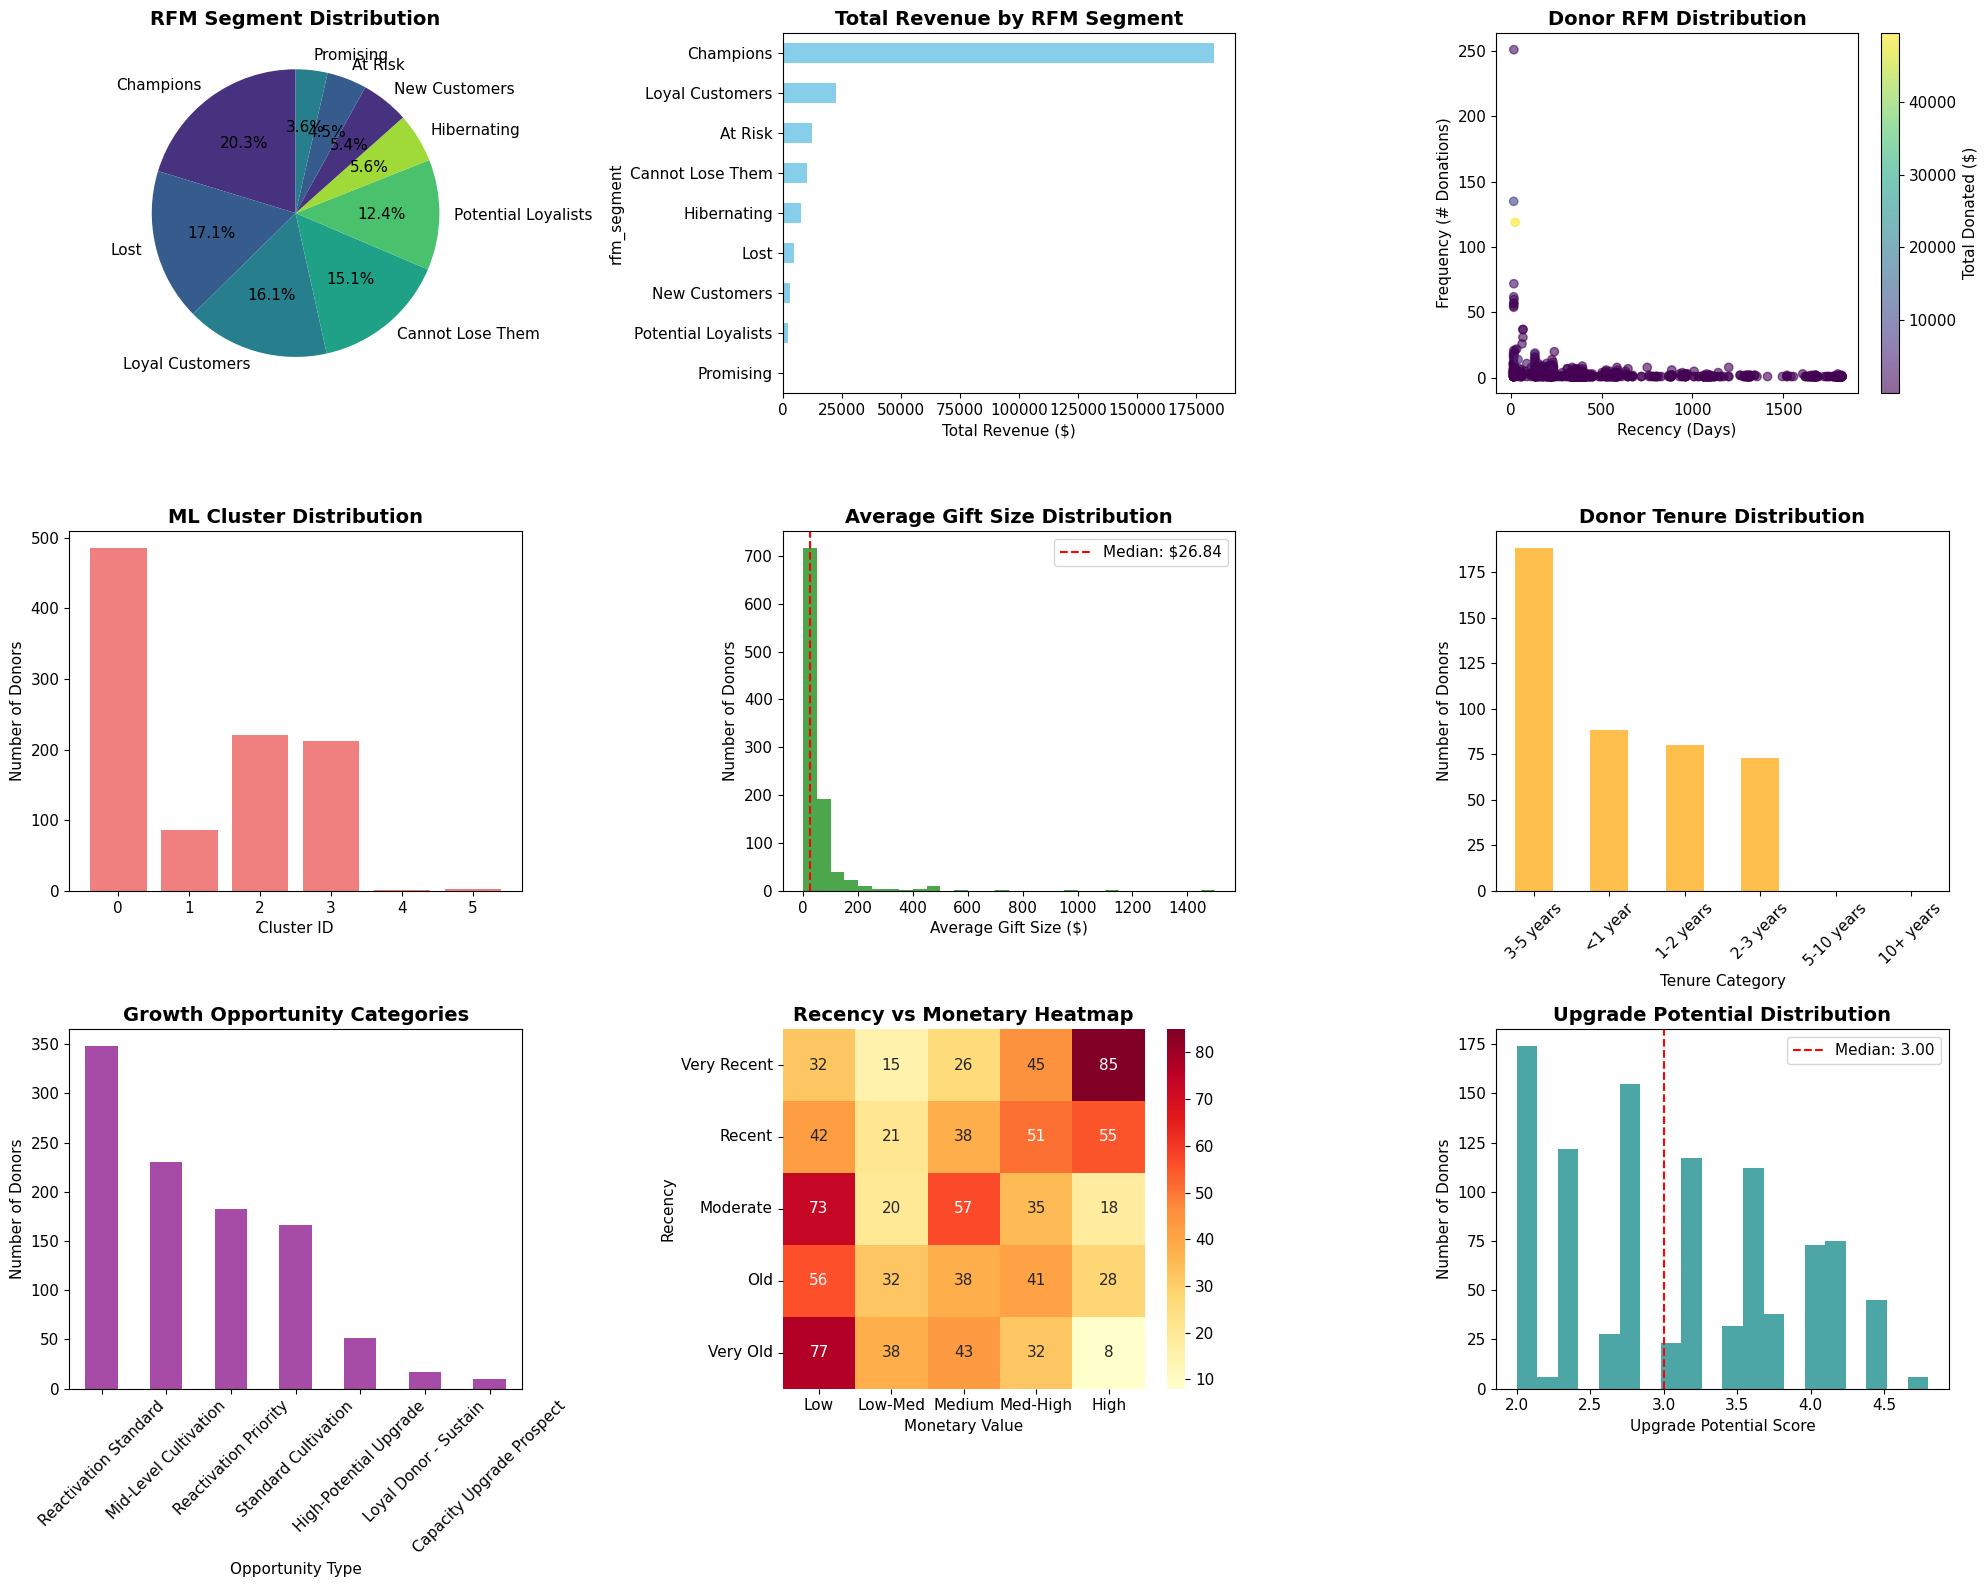

✅ Segmentation dashboard created and saved as 'donor_segmentation_dashboard.png'


In [10]:
def create_segmentation_dashboard(rfm_df, clustered_data, growth_analysis):
    """Create comprehensive segmentation visualization dashboard."""
    
    if rfm_df is None:
        print("❌ No data available for visualization")
        return
    
    print("📊 Creating segmentation dashboard...")
    
    # Create a comprehensive dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # 1. RFM Segment Distribution
    plt.subplot(3, 3, 1)
    rfm_counts = rfm_df['rfm_segment'].value_counts()
    plt.pie(rfm_counts.values, labels=rfm_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('RFM Segment Distribution', fontsize=14, fontweight='bold')
    
    # 2. Revenue by RFM Segment
    plt.subplot(3, 3, 2)
    segment_revenue = rfm_df.groupby('rfm_segment')['total_donated'].sum().sort_values(ascending=True)
    segment_revenue.plot(kind='barh', color='skyblue')
    plt.title('Total Revenue by RFM Segment', fontsize=14, fontweight='bold')
    plt.xlabel('Total Revenue ($)')
    
    # 3. RFM Scatter Plot (Recency vs Frequency)
    plt.subplot(3, 3, 3)
    scatter = plt.scatter(rfm_df['recency_days'], rfm_df['donation_frequency'], 
                         c=rfm_df['total_donated'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Total Donated ($)')
    plt.xlabel('Recency (Days)')
    plt.ylabel('Frequency (# Donations)')
    plt.title('Donor RFM Distribution', fontsize=14, fontweight='bold')
    
    # 4. Cluster Analysis (if available)
    if clustered_data is not None:
        plt.subplot(3, 3, 4)
        cluster_counts = clustered_data['cluster'].value_counts().sort_index()
        plt.bar(cluster_counts.index, cluster_counts.values, color='lightcoral')
        plt.title('ML Cluster Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Donors')
    
    # 5. Gift Size Distribution
    plt.subplot(3, 3, 5)
    plt.hist(rfm_df['avg_donation'], bins=30, alpha=0.7, color='green')
    plt.axvline(rfm_df['avg_donation'].median(), color='red', linestyle='--', 
                label=f'Median: ${rfm_df["avg_donation"].median():.2f}')
    plt.title('Average Gift Size Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Average Gift Size ($)')
    plt.ylabel('Number of Donors')
    plt.legend()
    
    # 6. Donor Tenure Analysis
    plt.subplot(3, 3, 6)
    tenure_bins = [0, 365, 730, 1095, 1825, 3650, float('inf')]
    tenure_labels = ['<1 year', '1-2 years', '2-3 years', '3-5 years', '5-10 years', '10+ years']
    rfm_df['tenure_category'] = pd.cut(rfm_df['tenure_days'], bins=tenure_bins, labels=tenure_labels)
    tenure_counts = rfm_df['tenure_category'].value_counts()
    tenure_counts.plot(kind='bar', color='orange', alpha=0.7)
    plt.title('Donor Tenure Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Tenure Category')
    plt.ylabel('Number of Donors')
    plt.xticks(rotation=45)
    
    # 7. Growth Opportunity Analysis (if available)
    if growth_analysis is not None:
        plt.subplot(3, 3, 7)
        opp_counts = growth_analysis['opportunity_category'].value_counts()
        opp_counts.plot(kind='bar', color='purple', alpha=0.7)
        plt.title('Growth Opportunity Categories', fontsize=14, fontweight='bold')
        plt.xlabel('Opportunity Type')
        plt.ylabel('Number of Donors')
        plt.xticks(rotation=45)
    
    # 8. Recency vs Monetary Heatmap
    plt.subplot(3, 3, 8)
    # Create recency and monetary bins for heatmap
    rfm_df['recency_bin'] = pd.qcut(rfm_df['recency_days'], 5, labels=['Very Recent', 'Recent', 'Moderate', 'Old', 'Very Old'])
    rfm_df['monetary_bin'] = pd.qcut(rfm_df['total_donated'], 5, labels=['Low', 'Low-Med', 'Medium', 'Med-High', 'High'])
    
    heatmap_data = rfm_df.groupby(['recency_bin', 'monetary_bin']).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Recency vs Monetary Heatmap', fontsize=14, fontweight='bold')
    plt.xlabel('Monetary Value')
    plt.ylabel('Recency')
    
    # 9. Upgrade Potential Distribution (if available)
    if growth_analysis is not None and 'upgrade_potential' in growth_analysis.columns:
        plt.subplot(3, 3, 9)
        plt.hist(growth_analysis['upgrade_potential'], bins=20, alpha=0.7, color='teal')
        plt.axvline(growth_analysis['upgrade_potential'].median(), color='red', linestyle='--',
                   label=f'Median: {growth_analysis["upgrade_potential"].median():.2f}')
        plt.title('Upgrade Potential Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Upgrade Potential Score')
        plt.ylabel('Number of Donors')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('/Users/mdassow/development/Neon_CRM_SDK/analysis/donor_segmentation_dashboard.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Segmentation dashboard created and saved as 'donor_segmentation_dashboard.png'")

# Create the dashboard
if rfm_df is not None:
    create_segmentation_dashboard(rfm_df, clustered_data, growth_analysis)
else:
    print("⚠️ Skipping dashboard creation - no data available")

## 7. Strategic Recommendations

Data-driven recommendations for donor cultivation and growth.

In [11]:
def generate_segmentation_recommendations(rfm_df, segment_summary, opportunity_summary, high_potential):
    """Generate strategic recommendations based on segmentation analysis."""
    
    print("🎯 SEGMENTATION STRATEGIC RECOMMENDATIONS")
    print("=" * 55)
    
    recommendations = []
    
    if segment_summary is not None:
        # 1. Champion Donors
        if 'Champions' in segment_summary.index:
            champions = segment_summary.loc['Champions']
            recommendations.append({
                'segment': 'Champions',
                'priority': 'HIGH',
                'strategy': 'VIP Stewardship Program',
                'action': 'Create exclusive events, personal thank-you calls, and major gift pipeline',
                'donors': int(champions['donor_count']),
                'revenue': champions['total_revenue']
            })
        
        # 2. At Risk Donors
        if 'At Risk' in segment_summary.index:
            at_risk = segment_summary.loc['At Risk']
            recommendations.append({
                'segment': 'At Risk',
                'priority': 'HIGH',
                'strategy': 'Urgent Retention Campaign',
                'action': 'Personal outreach, impact reports, and re-engagement activities',
                'donors': int(at_risk['donor_count']),
                'revenue': at_risk['total_revenue']
            })
        
        # 3. New Customers
        if 'New Customers' in segment_summary.index:
            new_customers = segment_summary.loc['New Customers']
            recommendations.append({
                'segment': 'New Customers',
                'priority': 'MEDIUM',
                'strategy': 'New Donor Journey',
                'action': 'Welcome series, education about impact, and second gift cultivation',
                'donors': int(new_customers['donor_count']),
                'revenue': new_customers['total_revenue']
            })
    
    if opportunity_summary is not None:
        # 4. High-Potential Upgrades
        if 'High-Potential Upgrade' in opportunity_summary.index:
            upgrades = opportunity_summary.loc['High-Potential Upgrade']
            recommendations.append({
                'segment': 'High-Potential Upgrade',
                'priority': 'HIGH',
                'strategy': 'Capacity Building Campaign',
                'action': 'Personal cultivation, capacity assessment, and major gift proposals',
                'donors': int(upgrades['donor_count']),
                'revenue': upgrades['total_revenue']
            })
        
        # 5. Reactivation Priorities
        if 'Reactivation Priority' in opportunity_summary.index:
            reactivation = opportunity_summary.loc['Reactivation Priority']
            recommendations.append({
                'segment': 'Reactivation Priority',
                'priority': 'MEDIUM',
                'strategy': 'Win-Back Campaign',
                'action': 'Targeted messaging about new initiatives and renewed impact',
                'donors': int(reactivation['donor_count']),
                'revenue': reactivation['total_revenue']
            })
    
    # Display recommendations
    for i, rec in enumerate(recommendations, 1):
        priority_emoji = '🔴' if rec['priority'] == 'HIGH' else '🟡'
        
        print(f"\n{priority_emoji} RECOMMENDATION {i}: {rec['segment']} [{rec['priority']} PRIORITY]")
        print(f"   Strategy: {rec['strategy']}")
        print(f"   Action: {rec['action']}")
        print(f"   Donors Affected: {rec['donors']:,}")
        print(f"   Revenue Potential: ${rec['revenue']:,.2f}")
    
    # High-potential prospects
    if high_potential is not None and len(high_potential) > 0:
        print(f"\n🎯 TOP UPGRADE PROSPECTS (Sample):")
        print("=" * 35)
        top_prospects = high_potential.head(10)
        for idx, prospect in top_prospects.iterrows():
            print(f"   Account ID {prospect['Account ID']}: ")
            print(f"     • Total Given: ${prospect['total_donated']:,.2f}")
            print(f"     • Avg Gift: ${prospect['avg_donation']:.2f}")
            print(f"     • Frequency: {prospect['donation_frequency']} gifts")
            print(f"     • Last Gift: {prospect['recency_days']} days ago")
            print(f"     • Upgrade Score: {prospect['upgrade_potential']:.2f}")
            print()
    
    # Implementation roadmap
    print(f"\n📋 IMPLEMENTATION ROADMAP")
    print("=" * 30)
    print("🔥 IMMEDIATE (30 days):")
    print("   • Launch urgent retention campaigns for at-risk major donors")
    print("   • Begin personal cultivation of top upgrade prospects")
    print("   • Implement VIP stewardship for Champions")
    
    print("\n⚡ SHORT-TERM (90 days):")
    print("   • Deploy new donor welcome sequences")
    print("   • Execute win-back campaigns for lapsed donors")
    print("   • Establish capacity assessment processes")
    
    print("\n🚀 LONG-TERM (6-12 months):")
    print("   • Build comprehensive donor journey mapping")
    print("   • Implement predictive analytics for prospect identification")
    print("   • Establish regular segmentation review cycles")
    
    return recommendations

# Generate recommendations
if rfm_df is not None:
    recommendations = generate_segmentation_recommendations(rfm_df, segment_summary, opportunity_summary, high_potential)
else:
    print("⚠️ No data available for recommendations")
    recommendations = []

🎯 SEGMENTATION STRATEGIC RECOMMENDATIONS

🔴 RECOMMENDATION 1: Champions [HIGH PRIORITY]
   Strategy: VIP Stewardship Program
   Action: Create exclusive events, personal thank-you calls, and major gift pipeline
   Donors Affected: 204
   Revenue Potential: $182,415.68

🔴 RECOMMENDATION 2: At Risk [HIGH PRIORITY]
   Strategy: Urgent Retention Campaign
   Action: Personal outreach, impact reports, and re-engagement activities
   Donors Affected: 45
   Revenue Potential: $12,457.60

🟡 RECOMMENDATION 3: New Customers [MEDIUM PRIORITY]
   Strategy: New Donor Journey
   Action: Welcome series, education about impact, and second gift cultivation
   Donors Affected: 54
   Revenue Potential: $3,195.24

🔴 RECOMMENDATION 4: High-Potential Upgrade [HIGH PRIORITY]
   Strategy: Capacity Building Campaign
   Action: Personal cultivation, capacity assessment, and major gift proposals
   Donors Affected: 52
   Revenue Potential: $99,391.44

🟡 RECOMMENDATION 5: Reactivation Priority [MEDIUM PRIORITY]
  

## Summary

This donor segmentation and growth analysis provides:

### ✅ Analysis Completed:
- **RFM Segmentation**: Classic recency, frequency, monetary analysis
- **Machine Learning Clustering**: Advanced behavioral segmentation
- **Growth Opportunity Identification**: Upgrade prospects and cultivation priorities
- **Strategic Recommendations**: Data-driven cultivation strategies

### 🎯 Key Insights:
- Donor behavior patterns and lifecycle stages
- High-value prospect identification
- Retention and reactivation opportunities
- Revenue optimization strategies

### 📊 Deliverables:
- Comprehensive segmentation dashboard
- Prioritized cultivation recommendations
- High-potential prospect lists
- Implementation roadmap

### 🔧 Safety Features:
- All operations are read-only
- No database modifications
- Robust error handling
- Data validation throughout

This analysis enables data-driven donor development strategies to maximize fundraising effectiveness and donor lifetime value.